<a href="https://colab.research.google.com/github/fboldt/postre/blob/main/aula6b_%C3%81rvores_de_decis%C3%A3o_atributos_cont%C3%ADnuos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Árvore de decisão para atributos contínuos

In [64]:
from sklearn.datasets import load_iris
dataset = load_iris()
X, y = dataset.data, dataset.target

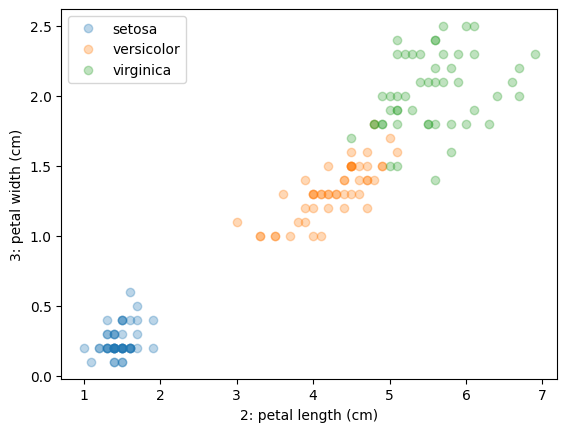

In [65]:
import matplotlib.pyplot as plt
i, j = 2, 3
plt.xlabel(f"{i}: {dataset.feature_names[i]}")
plt.ylabel(f"{j}: {dataset.feature_names[j]}")

for k in set(y):
  plt.plot(X[:,i][y==k], X[:,j][y==k], 'o', alpha=0.3,
           label=f"{dataset.target_names[k]}")
plt.legend()
plt.show()

In [66]:
from sklearn.base import BaseEstimator, ClassifierMixin
from collections import Counter
import numpy as np
from sklearn.model_selection import cross_validate

def maisFrequente(y):
  return Counter(y.flat).most_common(1)[0][0]

class ZeroR(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    y[:] = self.resposta
    return y

scores = cross_validate(ZeroR(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333]),
 0.3333333333333333)

In [67]:
modelo = ZeroR()
modelo.fit(X, y)
modelo.resposta

0

In [68]:
modelo = ZeroR()
modelo.fit(X, y)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

0.3333333333333333

In [69]:
class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.caracteristica = 2
    self.valor = np.mean(X[:,self.caracteristica])
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    if hasattr(self, 'resposta'):
      y[:] = self.resposta
    else:
      maiores = X[:,self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

modelo = Arvore()
modelo.fit(X, y)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

0.9533333333333334

In [70]:
scores = cross_validate(Arvore(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.93333333, 0.93333333, 0.8       , 0.93333333, 1.        ]),
 0.9200000000000002)

In [71]:
def impureza(y): #Gini
  labels = list(set(y))
  labels.sort()
  probabilidades = np.zeros((len(labels),))
  for i, k in enumerate(labels):
    probabilidades[i] = sum(y==k)/len(y)
  result = 1 - sum(probabilidades ** 2)
  return result

impureza(y[:])

0.6666666666666667

In [72]:
def impurezaValor(x, y, valor):
  maiores = x > valor
  impurezamaiores = impureza(y[maiores])
  proporcaomaiores = sum(maiores)/len(y)
  impurezamenores = impureza(y[~maiores])
  proporcaomenores = sum(~maiores)/len(y)
  impurezaTotal = proporcaomaiores*impurezamaiores + proporcaomenores*impurezamenores
  return impurezaTotal, impurezamenores, impurezamaiores

impurezaValor(X[:,2], y, 2.5)

(0.3333333333333333, 0.0, 0.5)

In [74]:
def melhorValor(x, y):
    result = None
    menorImpureza = float('inf')
    x_sorted_indices = np.argsort(x)  # Obtém os índices ordenados dos valores de x
    for i in range(len(x) - 1):
        idx1, idx2 = x_sorted_indices[i], x_sorted_indices[i+1]
        valor = (x[idx1] + x[idx2]) / 2  # Calcula a média entre dois valores consecutivos
        impTotal, impMenores, impMaiores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
    return result, menorImpureza

melhorValor(X[:,2], y)

(1.05, 0.6621923937360179)

In [75]:
def melhorCaracteristica(X, y):
  impurezas = []
  valores = []
  for caracteristica in range(X.shape[1]):
    valor, imp = melhorValor(X[:,caracteristica], y)
    impurezas.append(imp)
    valores.append(valor)
  # print(impurezas)
  # print(valores)
  impurezas = np.array(impurezas)
  caracteristica = np.argmin(impurezas)
  return impurezas[caracteristica], caracteristica, valores[caracteristica]

melhorCaracteristica(X, y)

(0.6436781609195401, 3, 0.1)

In [76]:
class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.impureza, self.caracteristica, self.valor = melhorCaracteristica(X, y)
    if self.valor is None:
      self.valor = 0
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    if hasattr(self, 'resposta'):
      y[:] = self.resposta
    else:
      maiores = X[:,self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

modelo = Arvore()
modelo.fit(X, y)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

1.0

In [77]:
scores = cross_validate(Arvore(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.9       , 0.83333333, 0.83333333, 0.86666667, 1.        ]),
 0.8866666666666667)

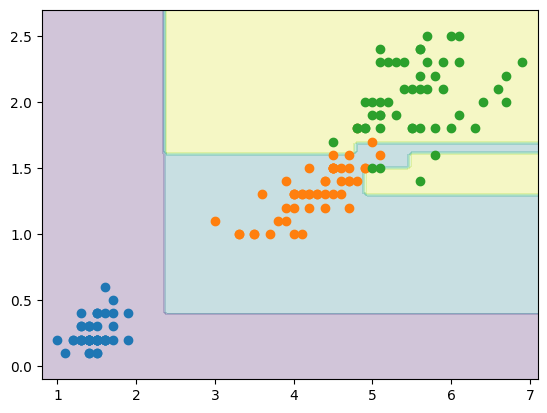

In [78]:
import matplotlib.pyplot as plt

def plotDecisao(modelo, X, y):
  modelo.fit(X, y)
  x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
  x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
  x0, x1 = np.meshgrid(x0s, x1s)
  Xdec = np.c_[x0.ravel(), x1.ravel()]
  ypred = modelo.predict(Xdec)
  plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
  for k in set(y):
    plt.plot(X[:,0][y==k], X[:,1][y==k], 'o')
  plt.show()

plotDecisao(Arvore(), X[:,2:], y)

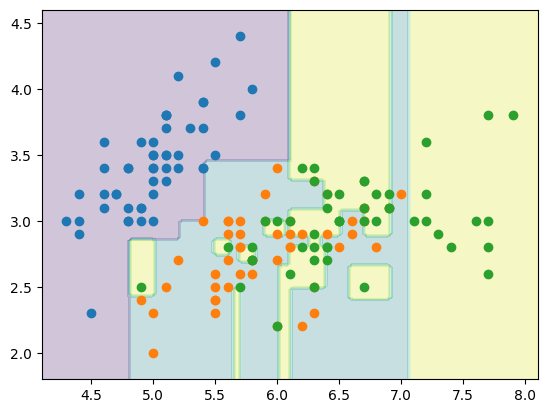

In [79]:
plotDecisao(Arvore(), X[:,:2], y)

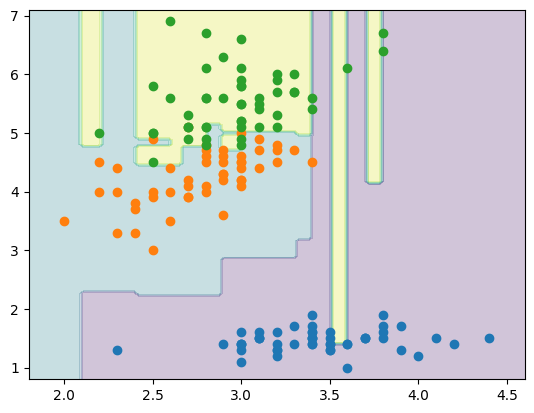

In [80]:
plotDecisao(Arvore(), X[:,1:3], y)

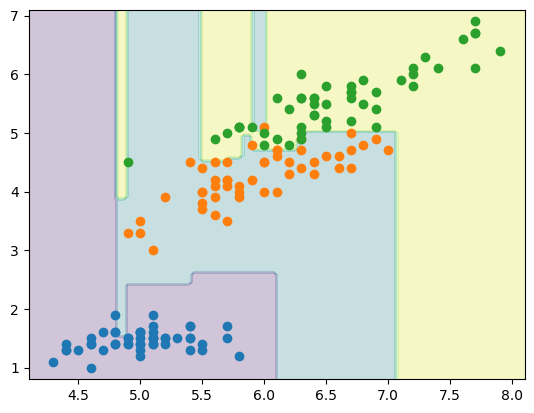

In [81]:
plotDecisao(Arvore(), X[:,[0,2]], y)

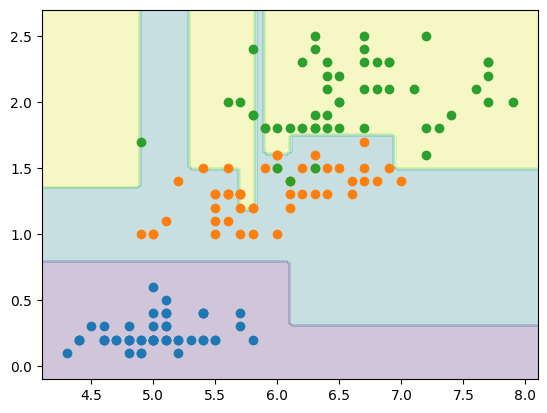

In [82]:
plotDecisao(Arvore(), X[:,[0,3]], y)

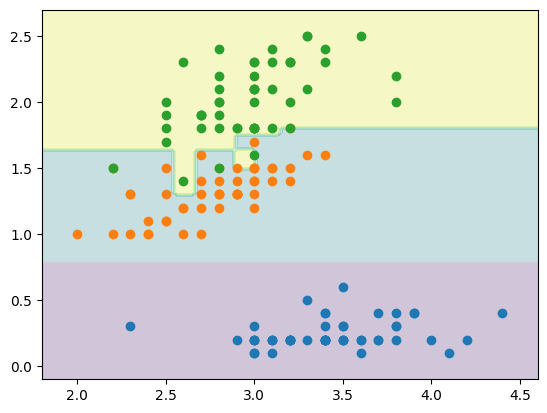

In [83]:
plotDecisao(Arvore(), X[:,[1,3]], y)

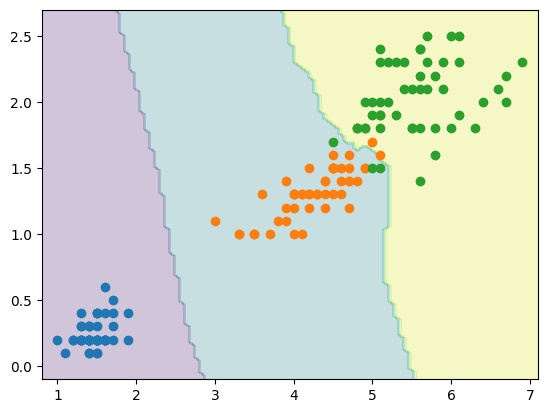

In [84]:
from sklearn.neighbors import KNeighborsClassifier
plotDecisao(KNeighborsClassifier(), X[:,2:], y)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


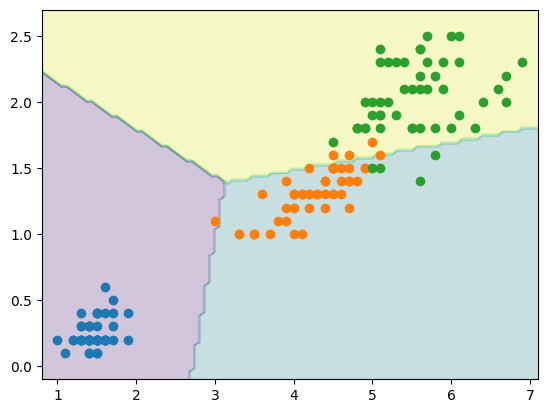

In [85]:
from sklearn.svm import LinearSVC
plotDecisao(LinearSVC(), X[:,2:], y)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


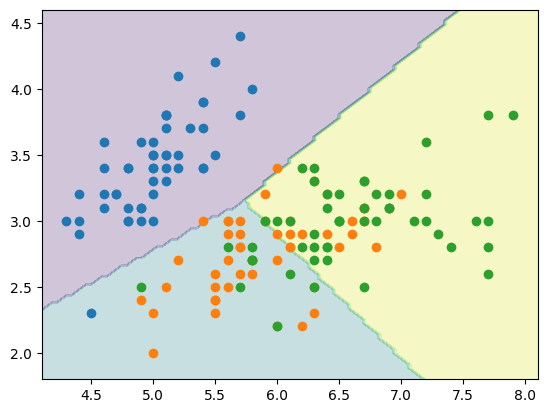

In [86]:
plotDecisao(LinearSVC(), X[:,:2], y)

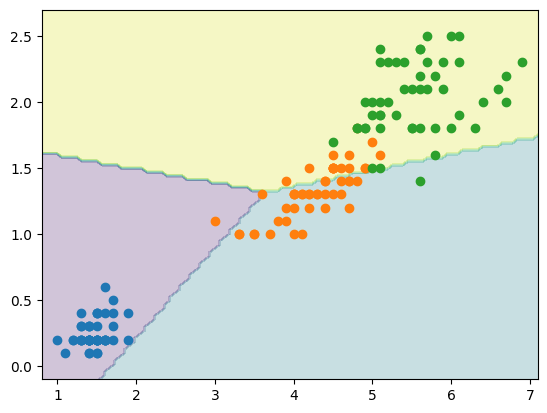

In [87]:
from sklearn.linear_model import Perceptron
plotDecisao(Perceptron(), X[:,2:], y)

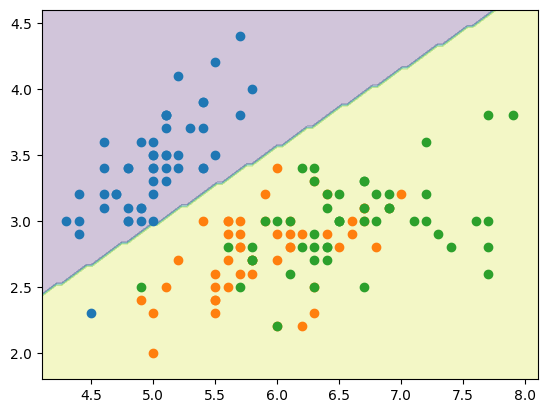

In [88]:
plotDecisao(Perceptron(), X[:,:2], y)